In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn :: utils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# sklearn :: models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

sns.set_style('whitegrid')

# Problem definition

Apply regression models to predict # bixi rides 

# Load the data

In [2]:
df = pd.read_csv('../../Data/Processed/bixiWeather.csv',low_memory=False)
print(df.columns)

Index(['start_date', 'weekday', 'month', 'hour', 'num_week',
       'start_station_code', 'end_date', 'end_station_code', 'duration_min',
       'is_member', 'datetime', 'humidity', 'pressure', 'temp_celsius',
       'description', 'wind_speed', 'wind_direction'],
      dtype='object')


In [3]:
df_bixi_model=df.drop(['start_date','start_station_code','end_date','end_station_code','duration_min','is_member','datetime'],axis=1)

In [4]:
df = df_bixi_model.groupby(['num_week','weekday','hour']).agg('first')
df['num_trips'] = df_bixi_model.groupby(['num_week','weekday','hour']).count()['description']
df = df.reset_index(level=[0,1,2])



# Feature Engineering 

In [8]:
# feature engineering
X_columns = ['num_week', 'weekday', 'hour', 'pressure', 'temp_celsius', 'humidity', 'wind_speed'] 
y_column = ['num_trips']

# Model Training

In [9]:
# split the data

threshold = 0.8
X = df[X_columns]
y = df[y_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1.0-threshold)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (3244, 7)
y_train (3244, 1)
X_test (812, 7)
y_test (812, 1)


# Model Training / Evaluation - Using Split

MODEL LinearRegression
MAE 521.9766356249385
RMSE 673.6592731797817


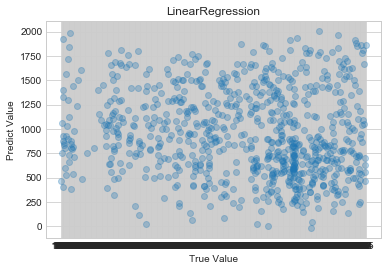

Feature Importance
              0          1
2          hour  52.856489
4  temp_celsius  25.715120
3      pressure  13.165071
0      num_week   9.629732
5      humidity   2.269316

MODEL RandomForestRegressor
MAE 160.6338669950739
RMSE 271.66369147987535


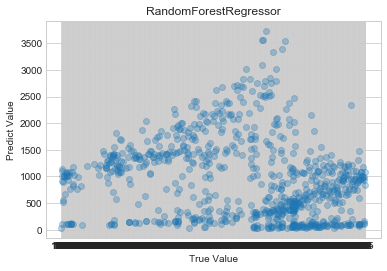

Feature Importance
              0         1
2          hour  0.671631
0      num_week  0.098284
1       weekday  0.079173
4  temp_celsius  0.067923
5      humidity  0.034765

MODEL RandomForestRegressor10
MAE 166.71687192118227
RMSE 277.78555686617017


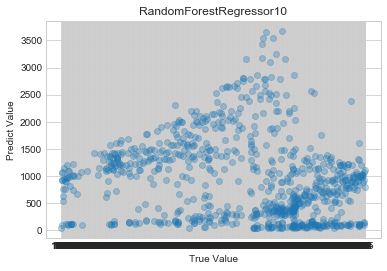

Feature Importance
              0         1
2          hour  0.671704
0      num_week  0.102376
1       weekday  0.076198
4  temp_celsius  0.066667
5      humidity  0.033542

MODEL RandomForestRegressor100
MAE 154.18322660098525
RMSE 260.6385004087466


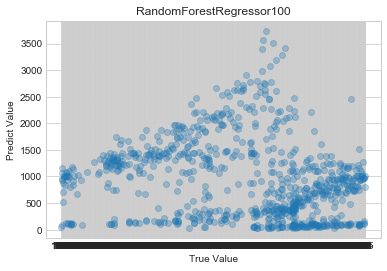

Feature Importance
              0         1
2          hour  0.669007
0      num_week  0.096604
1       weekday  0.076138
4  temp_celsius  0.072634
5      humidity  0.035082

MODEL KNeighborsRegressor
MAE 330.6192118226601
RMSE 488.27641670809834


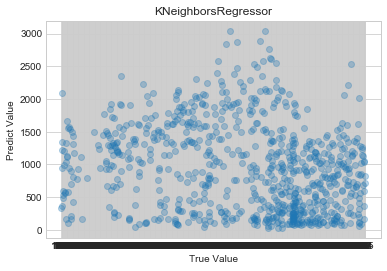


MODEL DecisionTreeRegressor
MAE 214.5652709359606
RMSE 387.5484190312174


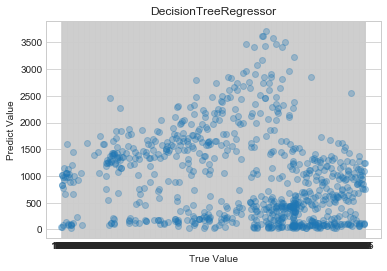

Feature Importance
              0         1
2          hour  0.676103
0      num_week  0.105417
1       weekday  0.078224
4  temp_celsius  0.062908
3      pressure  0.036043



,model,mae,rmse
3,RandomForestRegressor100,154.183227,260.638500
1,RandomForestRegressor,160.633867,271.663691
2,RandomForestRegressor10,166.716872,277.785557
5,DecisionTreeRegressor,214.565271,387.548419
4,KNeighborsRegressor,330.619212,488.276417
0,LinearRegression,521.976636,673.659273


In [10]:
models = [
    ('LinearRegression', LinearRegression()),
    ('RandomForestRegressor', RandomForestRegressor()),
    ('RandomForestRegressor10', RandomForestRegressor(n_estimators=10)),
    ('RandomForestRegressor100', RandomForestRegressor(n_estimators=100)),
    ('KNeighborsRegressor', KNeighborsRegressor()),
    ('DecisionTreeRegressor', DecisionTreeRegressor())
]
results = []
for m in models:
    print('MODEL', m[0])
    model = m[1]
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print('MAE', mae)
    print('RMSE', rmse)
    # print the chart
    plt.scatter(y_test, y_pred, alpha=0.3)
#     plt.plot(range(0,5000000, 100), range(0,5000000, 100), '--r', alpha=0.3, label='Line1')
    plt.title(m[0])
    plt.xlabel('True Value')
    plt.ylabel('Predict Value')
#     plt.xlim([0, 5000000])
#     plt.ylim([0, 5000000])
    plt.show()
    results.append([m[0], mae, rmse])
    
    # if there is a feature importance, print top 5
    importance = []
    if hasattr(model, 'feature_importances_'):
        print('Feature Importance')
        importance = []
        for i in range(len(X_columns)):
            importance.append([X_columns[i], model.feature_importances_[i]])
        print(pd.DataFrame(importance).sort_values(by=1, ascending=False).head())
    elif hasattr(model, 'coef_'):
        print('Feature Importance')
        for i in range(len(X_columns)):
            importance.append([X_columns[i], model.coef_[i]])
        print(pd.DataFrame(importance).sort_values(by=1, ascending=False).head())
        
    print('')

# sort the results and print as a table
df_results = pd.DataFrame(results)
df_results.columns = ['model', 'mae', 'rmse']
df_results = df_results.sort_values(by='mae')
df_results

# Model Training / Evaluation - Cross Validation

In [11]:
models = [
    ('LinearRegression', LinearRegression()),
    ('RandomForestRegressor', RandomForestRegressor()),
    ('RandomForestRegressor10', RandomForestRegressor(n_estimators=10)),
    ('RandomForestRegressor100', RandomForestRegressor(n_estimators=100, n_jobs=4)),
    ('KNeighborsRegressor', KNeighborsRegressor()),
    ('DecisionTreeRegressor', DecisionTreeRegressor())
]

k = 10
results = {}
for m in models:
    print('MODEL', m[0])
    results[m[0]] = {'mae':[], 'rmse':[]}
    kf = KFold(n_splits=k)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        model = m[1]
        model.fit(X_train, y_train.ravel())
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results[m[0]]['mae'].append(mae)
        results[m[0]]['rmse'].append(rmse)

MODEL LinearRegression
MODEL RandomForestRegressor
MODEL RandomForestRegressor10
MODEL RandomForestRegressor100
MODEL KNeighborsRegressor
MODEL DecisionTreeRegressor


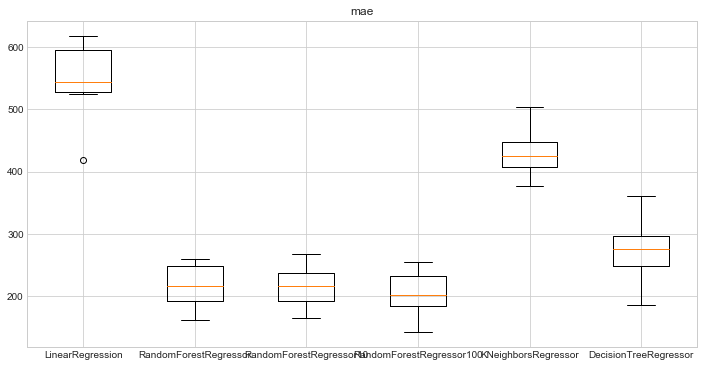

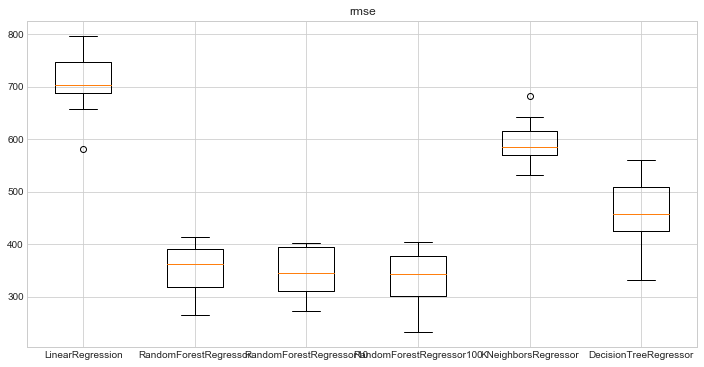

In [12]:
for metric in ['mae', 'rmse']:
    values = []
    labels = []
    for model, result_values in results.items():
        for m, v in result_values.items():
            if m == metric:
                labels.append(model)
                values.append(v)
    plt.figure(figsize=(12,6))
    plt.title(metric)
    plt.boxplot(values)
    plt.xticks(range(1, len(labels)+1), labels, rotation='horizontal')
    plt.show()